# Utility Functions

In [ ]:
# set the project path
%cd ~/projects/drug-pricing

In [5]:
from collections import Counter
from datetime import datetime, date
import functools as ft
import itertools as it
import os
from typing import List, Set, Tuple

import numpy as np
import pandas as pd
from praw import Reddit
from psaw import PushshiftAPI
import spacy
from spacy.lang.en import English
from spacy.tokens import DocBin
from tqdm import tqdm

from src.utils import connect_to_mongo
from src.schema import Post, User

/home/denhart.c/projects/drug-pricing


In [7]:
# project-wide variables/execution
nlp = spacy.load("en_core_web_sm")
connect_to_mongo()

# Read in data

# Summative Visualizations

## Date Distributions

In [5]:
full_df["date"] = full_df.time.apply(lambda ts: date(ts.year, ts.month, ts.day))
date_groups = full_df.groupby("date").count().reset_index()

In [ ]:
df_19 = date_groups.loc[date_groups["date"] >= date(2019, 1, 1), :]
sns.barplot(x="date", y="hash", data=df_19)

## Number of Posts Over Time

### Count of Submissions Over Time

Text(0.5, 1.0, 'Number of r/opiates Submissions Over Time')

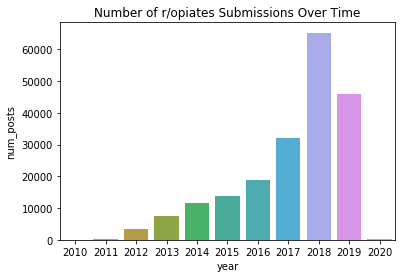

In [39]:
count_df = sub_df.groupby("year").count().reset_index().loc[:, ["year", "_id"]]
count_df.columns = ["year", "num_posts"]
norm_posts: List[float] = [p / u for p, u in zip(count_df["num_posts"], user_counts)]
ax = sns.barplot(x=count_df.year, y=count_df["num_posts"])
ax.set_title("Number of r/opiates Submissions Over Time")

### Count of Submissions + Comments Over Time

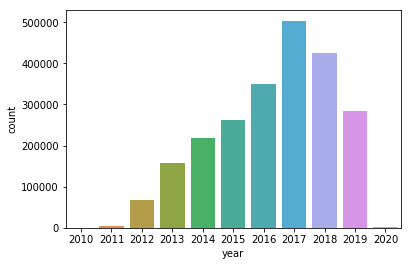

In [21]:
# group by year
query_str = { 
    "$group": { 
        "_id": { 
            "year": {"$year": "$time"}}, 
        "count": {
            "$sum": 1
        },
        "subs": {"$sum": 1}
    }
}
query = COLL.aggregate([query_str])

# extract data
query_li = list(query)
years = [str(it["_id"]["year"]) for it in query_li]
counts = [it["count"] for it in query_li]

# create dataframe
df = pd.DataFrame({"year": years, "count": counts})

# plot
sns.barplot(x="year", y="count", data=df)

### Count of Submissions + Real Comments

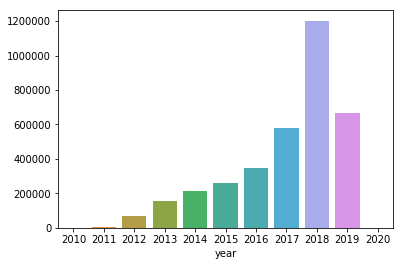

In [55]:
sub_df.query("year == '2017'").shape[0]
comms = sub_df.groupby("year")["num_comments"].sum().tolist()
subs = sub_df.groupby("year").count()
combined = [a + b for a, b in zip(comms, subs["hash"].tolist())]
sns.barplot(x=subs.index, y=combined)

### Real comments vs. extracted comments

In [44]:
real_comm_query = [
    {"$match": {
        "is_sub": True}},
    {"$group": {
        "_id": {"year": {"$year": "$time"}},
        "count": {"$sum": "$num_comments"}}}
]
real_res = COLL.aggregate(real_comm_query)
real_df = pd.DataFrame(list(real_res))
real_df["year"] = real_df["_id"].apply(lambda x: x["year"])

In [45]:
# group by year
raw_query = [
    {"$match": {"is_sub": False}},
    {"$group": {"_id": {"year": {"$year": "$time"}}, 
                "count": {"$sum": 1}}}
]
raw_res = COLL.aggregate(raw_query)
raw_df = pd.DataFrame(list(raw_res))
raw_df["year"] = raw_df["_id"].apply(lambda x: x["year"])

In [48]:
# combine dataframes
comm_df = real_df.merge(raw_df, on="year", how="inner")

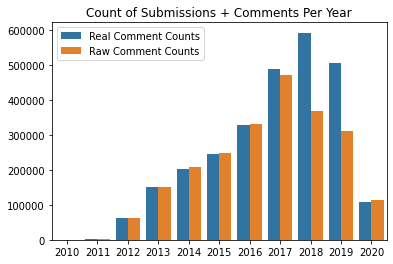

In [50]:
# plot
years = comm_df["year"].tolist() * 2
label = ["Real Comment Counts"] * comm_df.shape[0] + \
        ["Raw Comment Counts"] * comm_df.shape[0]
counts = comm_df["count_x"].tolist() + comm_df["count_y"].tolist()
ax = sns.barplot(x=years, y=counts, hue=label)
ax.set_title("Count of Submissions + Comments Per Year")
plt.show()

### Average Number of Comments Per Post Over Time

Text(0.5, 1.0, 'Average Number of Comments Per Post Over Time')

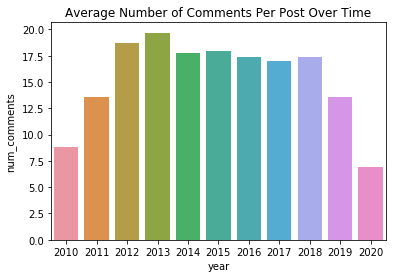

In [40]:
comm_df = sub_df.loc[:,["year", "num_comments"]].dropna().groupby("year")\
                                                .mean().reset_index()
ax = sns.barplot(x=comm_df.year, y=comm_df.num_comments)
ax.set_title("Average Number of Comments Per Post Over Time")

In [57]:
comm_counts = full_df.groupby("parent_id").count().reset_index()
comm_counts["new_par_id"] = comm_counts["parent_id"].apply(lambda x: x.replace("t1_", ""))

## Active Number of Users on R/Opiates Over Time

In [18]:
def users_per_year(df: pd.DataFrame) -> Tuple[List[str], List[int]]:
    """
    Find the number of unique users per year in the given df.
    
    Note: assumes columns names "username" and "year" in the df.
    """
    years: List[str] = list(df["year"].unique())
    user_counts: List[int] = [df.loc[df.year == year, "username"].unique().shape[0] for year in years]
    return years, user_counts

Text(0.5, 1.0, 'Number of r/opiates Active Users Over Time')

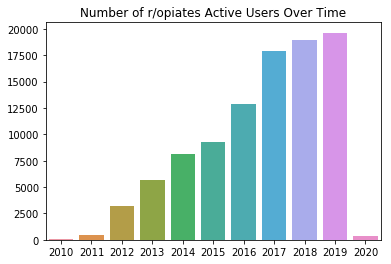

In [19]:
years, user_counts = users_per_year(full_df)
ax = sns.barplot(x=years, y=user_counts)
ax.set_title("Number of r/opiates Active Users Over Time")

## Frequency Table

In [245]:
freq_df = pd.DataFrame(list(COLL.find({})))
freq_df["year"] = freq_df.time.apply(lambda x: str(x.year))

In [246]:
freq_df["Threads"] = freq_df["is_sub"].apply(lambda x: 1 if x else 0)
freq_df["Comments"] = freq_df["is_sub"].apply(lambda x: 1 if (not x) else 0)
freq_df["Totals"] = [1] * freq_df.shape[0]
count_df = freq_df.groupby("year").sum().loc[:,["Threads", "Comments", "Totals"]]

In [247]:
count_df

,Threads,Comments,Totals
year,,,
2019,175.0,2162.0,2337.0


# Task Demonstrations

## spaCy Visualization

In [8]:
# query posts with san pedro
san_pedro_posts = Post.objects(text__icontains="san pedro")

ServerSelectionTimeoutError: 10.99.248.17:27017: [Errno 111] Connection refused